In [56]:
import numpy as np
import matplotlib.pyplot as plt

In [57]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [58]:
def squared_loss(yTrue, yPred):
    return np.mean(0.5 * (yTrue - yPred) ** 2)

In [59]:
def mean_squared_error(yTrue, yPred):
    return np.mean((yTrue - yPred) ** 2)

In [60]:
def sign_activation(yHat):
    return 1 if yHat >= 0 else 0


### Forward Pass

Let:
- $w_1 \in \mathbb{R}^2$, $b_1 \in \mathbb{R}$: weights and bias for hidden layer  
- $w_3 \in \mathbb{R}$, $b_2 \in \mathbb{R}$: weights and bias for output layer

Forward computation:
1. **Hidden layer pre-activation**:  
   $$
   z_1 = w_1^T x + b_1
   $$
2. **Hidden layer activation (sigmoid)**:  
   $$
   h = \sigma(z_1) = \frac{1}{1 + e^{-z_1}}
   $$
3. **Output**:  
   $$
   \hat{y} = w_3 \cdot h + b_2
   $$

---

### Backward Pass (Gradient Computation)

From the loss:  
$$
\mathcal{L} = \frac{1}{2}(y - \hat{y})^2
$$

Compute gradients:

1. Derivative w.r.t output:
   $$
   \frac{\partial \mathcal{L}}{\partial \hat{y}} = \hat{y} - y
   $$

2. Output layer parameters:
   $$
   \frac{\partial \mathcal{L}}{\partial w_3} = (\hat{y} - y) \cdot h
   $$
   $$
   \frac{\partial \mathcal{L}}{\partial b_2} = (\hat{y} - y)
   $$

3. Hidden layer gradients:

Let  
$$
\delta = (\hat{y} - y) \cdot w_3 \cdot h(1 - h)
$$

Then:
   $$
   \frac{\partial \mathcal{L}}{\partial w_1} = \delta \cdot x
   $$
   $$
   \frac{\partial \mathcal{L}}{\partial b_1} = \delta
   $$

---

### Parameter Updates (Gradient Descent)

Using learning rate $\eta$:

$$
w_1 \leftarrow w_1 - \eta \cdot \frac{\partial \mathcal{L}}{\partial w_1}
\quad
b_1 \leftarrow b_1 - \eta \cdot \frac{\partial \mathcal{L}}{\partial b_1}
$$

$$
w_3 \leftarrow w_3 - \eta \cdot \frac{\partial \mathcal{L}}{\partial w_3}
\quad
b_2 \leftarrow b_2 - \eta \cdot \frac{\partial \mathcal{L}}{\partial b_2}
$$

---

### Summary of Gradients

| Parameter | Gradient |
|----------|-----------|
| $w_3$ | $(\hat{y} - y) \cdot h$ |
| $b_2$ | $\hat{y} - y$ |
| $w_1$ | $(\hat{y} - y) \cdot w_3 \cdot h(1 - h) \cdot x$ |
| $b_1$ | $(\hat{y} - y) \cdot w_3 \cdot h(1 - h)$ |


In [61]:
def trainStep(x, y, w1, b1, w3, b2, learningRate):
    z1 = np.dot(w1, x) + b1
    h = sigmoid(z1)
    yHat = w3 * h + b2

    dL_dyHat = yHat - y

    dL_dw3 = dL_dyHat * h
    dL_db2 = dL_dyHat

    delta = dL_dyHat * w3 * h * (1 - h)
    dL_dw1 = delta * x
    dL_db1 = delta

    w1 -= learningRate * dL_dw1
    b1 -= learningRate * dL_db1
    w3 -= learningRate * dL_dw3
    b2 -= learningRate * dL_db2

    grads = {
        "dL_dw1": dL_dw1,
        "dL_db1": dL_db1,
        "dL_dw3": dL_dw3,
        "dL_db2": dL_db2
    }

    return w1, b1, w3, b2, yHat, grads

In [62]:
def predict(x, w1, b1, w3, b2):
    z1 = np.dot(w1, x) + b1
    h = sigmoid(z1)
    yHat = w3 * h + b2
    return sign_activation(yHat)  

In [63]:
def train(X, Y, X_test, y_test, learningRate=0.01, threshold=1e-3, patience=5, maxIterations=500):
    w1 = np.random.randn(2)      
    b1 = np.random.randn()      
    w3 = np.random.randn()       
    b2 = np.random.randn() 

    prevLoss = float('inf')
    noImprovement = 0

    history = {
        "iteration": [],
        "loss": [],
        "test_loss": [],  
        "weights": [],
        "predictions": [],
    }


    for iteration in range(maxIterations):
        predictions = []
        iterationGradients = []

        for x, y in zip(X, Y):
            w1, b1, w3, b2, yHat, grads = trainStep(x, y, w1, b1, w3, b2, learningRate)
            predictions.append(yHat)
            iterationGradients.append(grads)

        loss = squared_loss(Y, np.array(predictions))
        print(f"Iteration {iteration+1} | Loss: {loss:.4f}")

        history["iteration"].append(iteration + 1)
        history["loss"].append(loss)
        history["weights"].append({
            "w1": w1.copy(),
            "b1": b1,
            "w3": w3,
            "b2": b2,
            "grads": iterationGradients
        })
        history["predictions"].append(np.array(predictions))

        testPredictions = np.array([w3 * sigmoid(np.dot(w1, x) + b1) + b2 for x in X_test])
        testLoss = mean_squared_error(y_test, testPredictions)
        history["test_loss"].append(testLoss)

        if abs(prevLoss - loss) < threshold:
            noImprovement += 1
            if noImprovement >= patience:
                print("Training converged.")
                break
        else:
            noImprovement = 0

        prevLoss = loss

    return w1, b1, w3, b2, history

In [64]:
np.random.seed(2023217)

# 10 samples for each label
mean0 = [-1, -1]
mean1 = [1, 1]
cov = [[1, 0], [0, 1]]  

X0 = np.random.multivariate_normal(mean0, cov, 10)
X1 = np.random.multivariate_normal(mean1, cov, 10)

y0 = np.zeros(10)
y1 = np.ones(10)

X = np.vstack((X0, X1))
y = np.hstack((y0, y1))

indices = np.arange(20)
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

split = 10
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [65]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (10, 2)
y_train shape: (10,)
X_test shape: (10, 2)
y_test shape: (10,)


In [66]:
w1, b1, w3, b2, history = train(X_train, y_train, X_test, y_test)
yPred_test = np.array([predict(x, w1, b1, w3, b2) for x in X_test])
testLoss = mean_squared_error(y_test, yPred_test)
print(f"\n Test MSE: {testLoss:.4f}")

Iteration 1 | Loss: 0.9666
Iteration 2 | Loss: 0.7670
Iteration 3 | Loss: 0.6172
Iteration 4 | Loss: 0.5043
Iteration 5 | Loss: 0.4191
Iteration 6 | Loss: 0.3546
Iteration 7 | Loss: 0.3056
Iteration 8 | Loss: 0.2683
Iteration 9 | Loss: 0.2399
Iteration 10 | Loss: 0.2181
Iteration 11 | Loss: 0.2015
Iteration 12 | Loss: 0.1886
Iteration 13 | Loss: 0.1788
Iteration 14 | Loss: 0.1711
Iteration 15 | Loss: 0.1651
Iteration 16 | Loss: 0.1605
Iteration 17 | Loss: 0.1568
Iteration 18 | Loss: 0.1539
Iteration 19 | Loss: 0.1515
Iteration 20 | Loss: 0.1496
Iteration 21 | Loss: 0.1480
Iteration 22 | Loss: 0.1467
Iteration 23 | Loss: 0.1456
Iteration 24 | Loss: 0.1446
Iteration 25 | Loss: 0.1438
Iteration 26 | Loss: 0.1431
Iteration 27 | Loss: 0.1424
Iteration 28 | Loss: 0.1418
Training converged.

 Test MSE: 0.4000


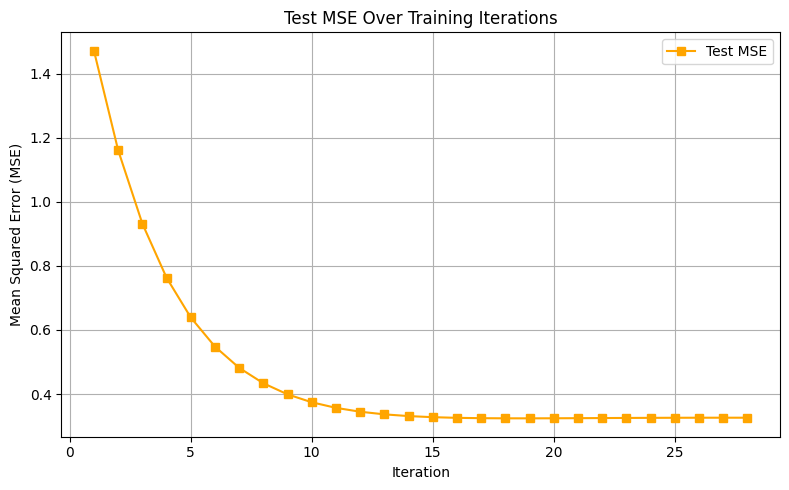

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history["iteration"], history["test_loss"], marker='s', color='orange', label="Test MSE")
plt.title("Test MSE Over Training Iterations")
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()